In [21]:
import pandas as pd
import optuna

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    balanced_accuracy_score,
    average_precision_score,
    log_loss,
    zero_one_loss,
)

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (
    StandardScaler,
    OneHotEncoder,
    LabelEncoder,
    OrdinalEncoder,
)

import plotly.express as px

from pathlib import Path

In [2]:
# import mlflow

# # mlflow ui
# mlflow.set_tracking_uri("http://localhost:5000")
# mlflow.set_experiment("street-tree-census")

In [1]:
data_path = Path("../data/processed/dataset.csv").resolve()
data = pd.read_csv(data_path)

target = ["health"]

cat_cols = [
    "curb_loc",
    "spc_common",
    "guards",
    "sidewalk",
    "user_type",
    "borough",
]

num_cols = [
    "block_id",
    "tree_dbh",
    "steward",
    "postcode",
    "cncldist",
    "st_senate",
    "nta",
    "ct",
    "x_sp",
    "y_sp",
    "problems",
    "root_problems",
    "trunk_problems",
    "brch_problems",
]

feature_cols = num_cols + cat_cols
target_col = ["health"]

NameError: name 'Path' is not defined

In [40]:
X = data.drop(columns=target)
y = data[target]

target_le = LabelEncoder()
y = target_le.fit_transform(y.squeeze())
y

X, X_test, y, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [44]:
target_le.classes_

array(['Fair', 'Good', 'Poor'], dtype=object)

In [47]:
def get_metrics(y_true, y_pred, pred_proba):
    cm = confusion_matrix(y_true, y_pred)

    accuracy = accuracy_score(y_true, y_pred)
    balanced_accuracy = balanced_accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average="weighted")
    average_precision = average_precision_score(y_true, pred_proba)
    recall = recall_score(y_true, y_pred, average="weighted")
    f1 = f1_score(y_true, y_pred, average="weighted")
    l_loss = log_loss(y_true, pred_proba)
    # roc_auc = roc_auc_score(y_true, pred_proba, multi_class="ovr")
    zo_loss = zero_one_loss(y_true, y_pred)
    # d2l_loss = d2_log_loss_score(y_true, pred_proba)

    # print(cm.ravel())

    ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_le.classes_).plot()
    print("Balanced accuracy:", balanced_accuracy)
    print("Average precision:", average_precision)
    print("F1 Score:", f1)
    print("log_loss", l_loss)
    # print("d2 log_loss", d2l_loss)
    # print("roc_auc", roc_auc)
    print("zo_loss", zo_loss)

Balanced accuracy: 0.3333333333333333
Average precision: 0.3333333333333333
F1 Score: 0.7259109024905946
log_loss 6.823953047336506
zo_loss 0.1893246773202213


/root/anaconda3/envs/analytics/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


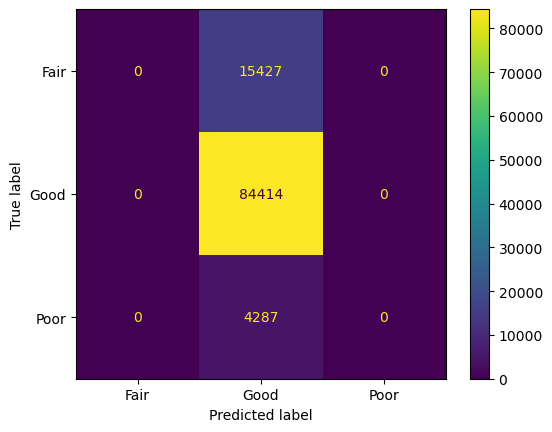

In [48]:
from sklearn.dummy import DummyClassifier

params = {"strategy": "most_frequent"}
dc = DummyClassifier(**params)
dc.fit(X_train, y_train)

y_pred_proba = dc.predict_proba(X_val)
y_pred = dc.predict(X_val)

get_metrics(y_val, y_pred, y_pred_proba)

Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV 1/2; 1/1] START model__C=100, model__max_iter=1000..........................
[CV 1/2; 1/1] END model__C=100, model__max_iter=1000;, score=0.811 total time=   9.5s
[CV 2/2; 1/1] START model__C=100, model__max_iter=1000..........................
[CV 2/2; 1/1] END model__C=100, model__max_iter=1000;, score=0.811 total time=  10.7s
Balanced accuracy: 0.3377066368079496
Average precision: 0.40789237050765365
F1 Score: 0.7297111513586119
log_loss 0.5551759567451704
zo_loss 0.18914220958819916


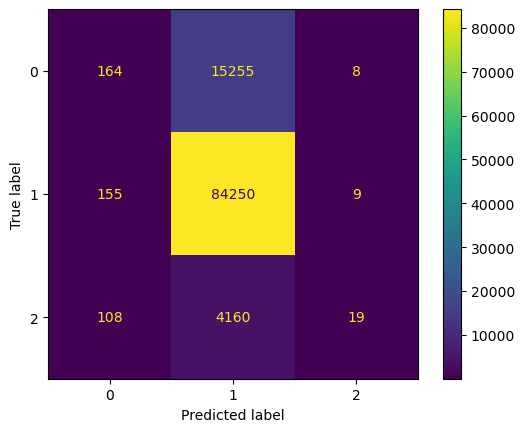

In [23]:
preprocessor = ColumnTransformer(
    transformers=[
        ("scaler", StandardScaler(), num_cols),
        ("encoder", OneHotEncoder(), cat_cols),
    ]
)

pipe = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("model", LogisticRegression(random_state=42)),
    ]
)

# param = {'model__C':[100, 10, 1, 0.1, 0.01, 0.001],
#          'model__max_iter': range(1000, 3000, 500)}

param = {"model__C": [100], "model__max_iter": [1000]}

pipemodel = GridSearchCV(
    estimator=pipe,
    cv=2,
    # scoring="f1_weighted",
    # scoring="neg_log_loss",
    param_grid=param,
    n_jobs=1,
    verbose=10,
)

pipemodel.fit(X_train, y_train)

y_pred_proba = pipemodel.predict_proba(X_val)
y_pred = pipemodel.predict(X_val)

get_metrics(y_val, y_pred, y_pred_proba)

Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV 1/2; 1/1] START model__C=100, model__max_iter=1000..........................
[CV 1/2; 1/1] END model__C=100, model__max_iter=1000;, score=0.730 total time=   8.1s
[CV 2/2; 1/1] START model__C=100, model__max_iter=1000..........................
[CV 2/2; 1/1] END model__C=100, model__max_iter=1000;, score=0.730 total time=   9.0s
Balanced accuracy: 0.3377066368079496
Average precision: 0.40789237050765365
F1 Score: 0.7297111513586119
log_loss 0.5551759567451704
zo_loss 0.18914220958819916


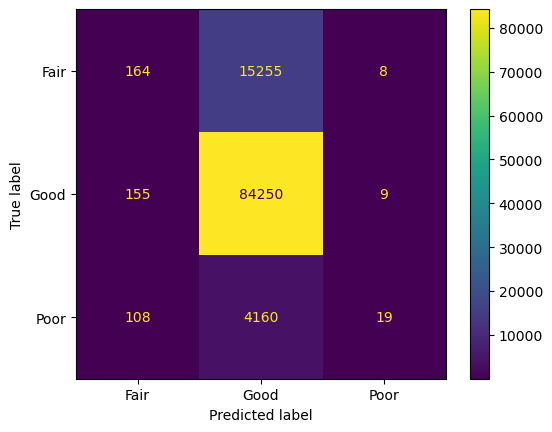

In [49]:
preprocessor = ColumnTransformer(
    transformers=[
        ("scaler", StandardScaler(), num_cols),
        ("encoder", OneHotEncoder(), cat_cols),
    ]
)

pipe = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("model", LogisticRegression(random_state=42)),
    ]
)

# param = {'model__C':[100, 10, 1, 0.1, 0.01, 0.001],
#          'model__max_iter': range(1000, 3000, 500)}

param = {"model__C": [100], "model__max_iter": [1000]}

pipemodel = GridSearchCV(
    estimator=pipe,
    cv=2,
    scoring="f1_macro",
    # scoring="neg_log_loss",
    param_grid=param,
    n_jobs=1,
    verbose=10,
)

pipemodel.fit(X_train, y_train)

y_pred_proba = pipemodel.predict_proba(X_val)
y_pred = pipemodel.predict(X_val)

get_metrics(y_val, y_pred, y_pred_proba)

Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV 1/2; 1/1] START model__C=100, model__max_iter=1000..........................
[CV 1/2; 1/1] END model__C=100, model__max_iter=1000;, score=-0.555 total time=   8.9s
[CV 2/2; 1/1] START model__C=100, model__max_iter=1000..........................
[CV 2/2; 1/1] END model__C=100, model__max_iter=1000;, score=-0.555 total time=  10.7s
Balanced accuracy: 0.3377066368079496
Average precision: 0.40789237050765365
F1 Score: 0.7297111513586119
log_loss 0.5551759567451704
zo_loss 0.18914220958819916


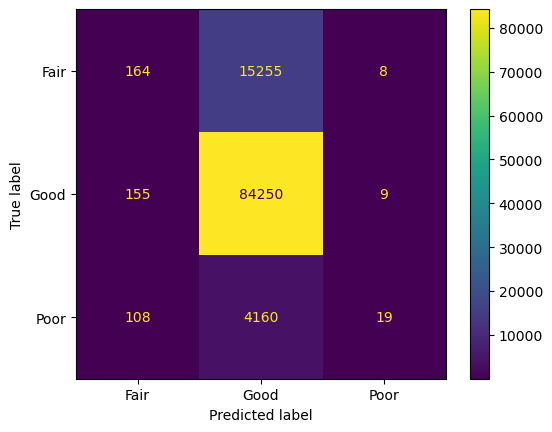

In [50]:
preprocessor = ColumnTransformer(
    transformers=[
        ("scaler", StandardScaler(), num_cols),
        ("encoder", OneHotEncoder(), cat_cols),
    ]
)

pipe = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("model", LogisticRegression(random_state=42)),
    ]
)

# param = {'model__C':[100, 10, 1, 0.1, 0.01, 0.001],
#          'model__max_iter': range(1000, 3000, 500)}

param = {"model__C": [100], "model__max_iter": [1000]}

pipemodel = GridSearchCV(
    estimator=pipe,
    cv=2,
    # scoring="f1_weighted",
    scoring="neg_log_loss",
    param_grid=param,
    n_jobs=1,
    verbose=10,
)

pipemodel.fit(X_train, y_train)

y_pred_proba = pipemodel.predict_proba(X_val)
y_pred = pipemodel.predict(X_val)

get_metrics(y_val, y_pred, y_pred_proba)

Fitting 2 folds for each of 24 candidates, totalling 48 fits
[CV 1/2; 1/24] START model__C=100, model__max_iter=1000.........................
[CV 1/2; 1/24] END model__C=100, model__max_iter=1000;, score=0.309 total time=   8.6s
[CV 2/2; 1/24] START model__C=100, model__max_iter=1000.........................
[CV 2/2; 1/24] END model__C=100, model__max_iter=1000;, score=0.309 total time=   9.8s
[CV 1/2; 2/24] START model__C=100, model__max_iter=1500.........................
[CV 1/2; 2/24] END model__C=100, model__max_iter=1500;, score=0.309 total time=   9.0s
[CV 2/2; 2/24] START model__C=100, model__max_iter=1500.........................
[CV 2/2; 2/24] END model__C=100, model__max_iter=1500;, score=0.309 total time=   9.4s
[CV 1/2; 3/24] START model__C=100, model__max_iter=2000.........................
[CV 1/2; 3/24] END model__C=100, model__max_iter=2000;, score=0.309 total time=   8.9s
[CV 2/2; 3/24] START model__C=100, model__max_iter=2000.........................
[CV 2/2; 3/24] END

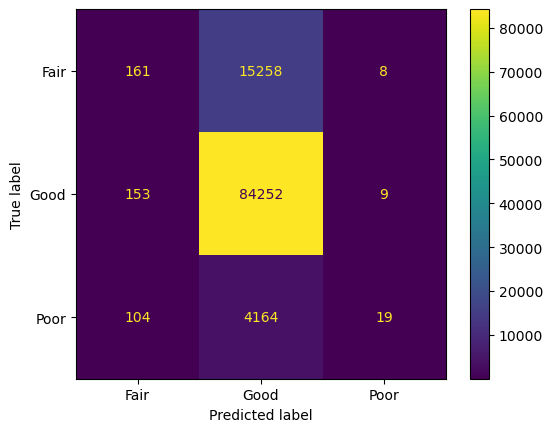

In [52]:
preprocessor = ColumnTransformer(
    transformers=[
        ("scaler", StandardScaler(), num_cols),
        ("encoder", OneHotEncoder(), cat_cols),
    ]
)

pipe = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("model", LogisticRegression(random_state=42)),
    ]
)

param = {'model__C':[100, 10, 1, 0.1, 0.01, 0.001],
         'model__max_iter': range(1000, 3000, 500)}

# param = {"model__C": [100], "model__max_iter": [1000]}

pipemodel = GridSearchCV(
    estimator=pipe,
    cv=2,
    scoring="f1_macro",
    # scoring="neg_log_loss",
    param_grid=param,
    n_jobs=1,
    verbose=5,
)

pipemodel.fit(X_train, y_train)

y_pred_proba = pipemodel.predict_proba(X_val)
y_pred = pipemodel.predict(X_val)

get_metrics(y_val, y_pred, y_pred_proba)